# Wizard Crawler 
*(noun)*
1. Crawls 'choose your own adventure'-style comment chains, and compiles them into a .json file.
2. Converts the result into an easy to navigate html.
3. For more info see the [Github repository](https://github.com/XkF21WNJ/WizardTree)

Thanks to /u/XiuathoTheWizard and everyone else who contributed to his story, for bringing the great folks at /r/TalesFromTechSupport a tale that won't soon be forgotten, and inspiring this project.

Code by /u/XkF21WNJ.

### Initialisation (run this first)

In [1]:
#Imports
import praw
import markdown as md
import json

#Definitions
def YieldAll(comments):
    for c in comments:
        if isinstance(c, praw.objects.MoreComments):
            for x in YieldAll(c.comments()): yield x
        else: yield c

def IsWizard(story, comment):
    return str(comment.author) == story['author']

def FindWizard(story, comments):
    for c in YieldAll(comments):
        if IsWizard(story, c): yield c
    
def ParseSubmission(story, submission):
    story['events'][submission.id] = {"description": md.markdown(submission.body), 
                                      "actions" : list(ParseReplies(story, submission.comments, submission.id)),
                                      "parent" : None,
                                      "url" : submission.url}
    return submission.id

def ParseComment(story, comment, parent):
    story['events'][comment.id] = {"description": md.markdown(comment.body), 
                                   "actions" : list(ParseReplies(story, comment.replies, comment.id)),
                                   "parent" : parent,
                                   "url" : comment.permalink}
    return comment.id

def ParseReplies(story, comments, parent):
    for r in YieldAll(comments):
        consequence = FindConsequence(story, r.replies, parent)
        if consequence == None: continue;
        story['actions'][r.id] = {"description": md.markdown(r.body),
                                  "consequence" : consequence,
                                  "actor" : r.author.name,
                                  "url" : r.permalink}
        story['actors'].append(r.author.name)
        yield r.id;
        
def FindConsequence(story, comments, parent):
    for c in FindWizard(story, comments):
        return ParseComment(story, c, parent)
        
def Crawl(content):    
    if isinstance(content, praw.objects.Submission):
        story = {'author' : content.author.name,
                 'url' : content.url,
                 'start' : content.id,
                 'title': content.title}
    elif isinstance(content, praw.objects.Comment):
        story = {'author' : content.author.name,
                 'url' : content.permalink,
                 'start' : content.id,
                 'title' : content.submission.title}
    
    story['events'] = {}
    story['actions'] = {}
    story['actors'] = []

    if isinstance(content, praw.objects.Submission):
        ParseSubmission(story, content)
    elif isinstance(content, praw.objects.Comment):
        ParseComment(story, content, None)
    
    #Finalize
    uniq_actors = list(set(story['actors']))
    uniq_actors.sort(key = story['actors'].count, reverse = True)
    story['actors'] = uniq_actors
    
    return story

def CrawlSubmission(url = None, submission_id = None):
    r = praw.Reddit(user_agent='WizardCrawler/0.1 (by /u/XkF21WNJ)')
    
    if (url != None):
        submission = r.get_submission(url=url)
    elif (submission_id != None):
        submission = r.get_submission(submission_id=submission_id)
    
    return Crawl(submission)

def CrawlComment(comment_id):
    r = praw.Reddit(user_agent='WizardCrawler/0.1 (by /u/XkF21WNJ)')
    comment = r.get_info(thing_id = "t1_"+comment_id)
    comment.refresh()
    return Crawl(comment)

def Import(filename):
    with open(filename,'r') as f:
        return json.load(f)

def Export(story, filename):
    with open(filename,'w') as f:
        json.dump(story, f, indent=4)

### Examples

##### Crawl and Save XiuathoTheWizard's tale as JSON

In [ ]:
story = CrawlComment("cy8z5uv")
Export(story, "Output/WizardTree.json")

##### Visualize story structure

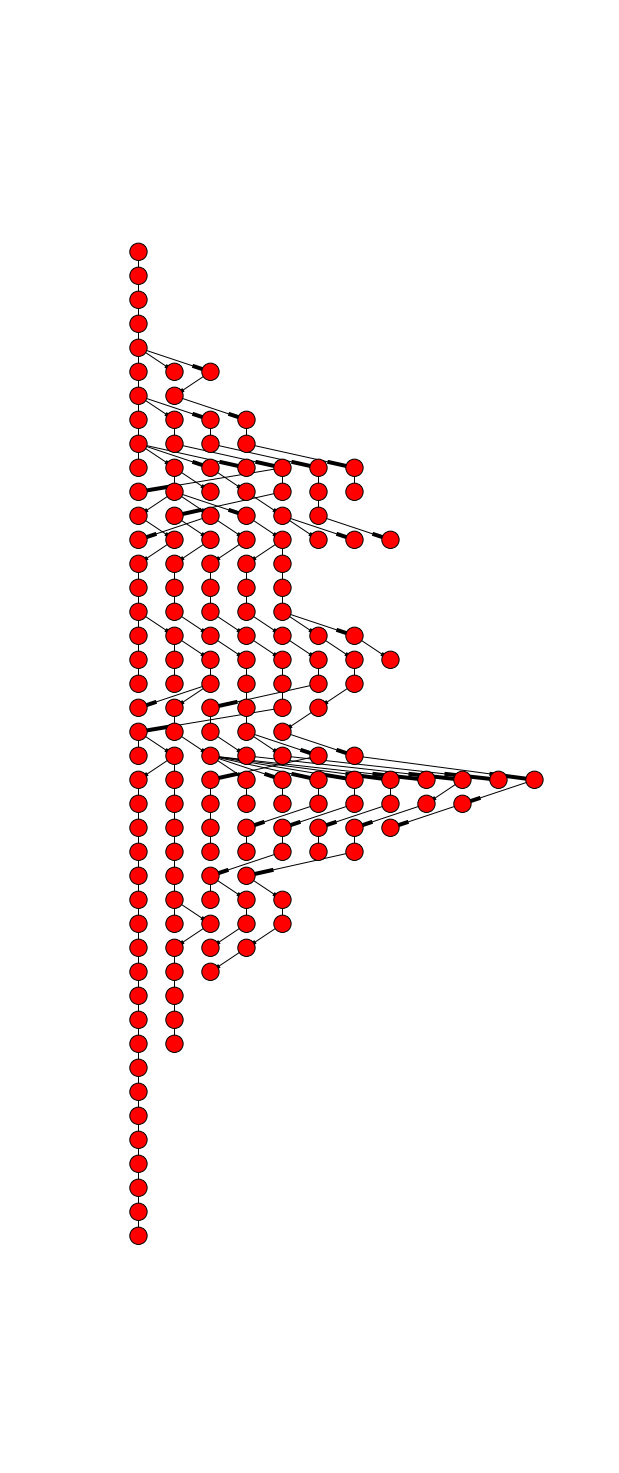

In [37]:
%matplotlib inline

#Imports
import networkx as nx
import matplotlib.pyplot as plt

#Load story
story = Import("Output/WizardTree.json")

#Build graph
G = nx.DiGraph()
for event_id in story['events']:
    event = story['events'][event_id]
    for action_id in event['actions']:
        action = story['actions'][action_id]
        G.add_edge(event_id, action['consequence'])

#Plot
shells = {}
pos = {}
for node in nx.dfs_preorder_nodes(G):
    depth = len(nx.ancestors(G, node))
    if depth in shells:
        shells[depth].append(node)
    else:
        shells[depth] = [node]
    pos[node] = [len(shells[depth]), -depth]

plt.figure(figsize=(8,20))
nx.draw(G, pos=pos, with_labels=False)
plt.show()

### HTML conversion

In [38]:
#Imports
from html import HTML

#Definitions
def Truncate(text):
    return text[:60] + (text[60:] and '..')

def ParseEvent(story, body, event_id, index):
    event = story['events'][event_id]
    div = body.div(klass = 'event')
    div.a('', name = event_id)
    
    links = div.div(klass = 'link-container')
    if event['parent'] != None:     
        links.a('Go to Previous', 
                href = '#'+event['parent'],
                klass = 'left-link')
    else:
        links.a('Go to Index', href = '#index', klass = 'left-link')
    links.a('Go to Original', href = event['url'], klass = 'right-link')
    
    div.text(event['description'], escape=False)
    
    for action_id in event['actions']:
        ParseAction(story, body, action_id, div.ul(), index)

def ParseAction(story, body, action_id, ul, index):
    action = story['actions'][action_id]
    href = '#'+action['consequence']
    
    indli = index.li()
    indli.a(action['description'], href = href, klass='action', style = 'display: block;', escape=False)
    
    li = ul.li(klass = 'action')
    a = li.a(href = href,
             style = "display: block;", 
             title = '/u/'+ action['actor'])
    
    a.span(action['description'], escape=False)
    ParseEvent(story, body, action['consequence'], index)

def ParseStory(story):    
    #Styling
    css = """
        body {
            font-family: arial, sans-serif;
            width: 40em;
            margin-left:auto;
            margin-right:auto;
        }
        
        p {
            text-align: justiy;
            -moz-hyphens: auto;
            hyphens: auto;
        }
        
        .event {
            margin-bottom: 1000ex;
        }
        
        .event > p {
            font-family: Georgia, serif;
            font-size: larger;
            line-height: 1.5em;
        }
        
        .action p {
            margin-top: 0.25em;
            margin-bottom: 0.25em;
        }
        
        .action {
            font-family: consolas, monospace;
            margin: 0 0 2ex 0;
        }
        
        .link-container {
            font-family: consolas, monospace;
            display: flex;
        }
        
        .left-link{
            width: 40ex;
        }
        
        .right-link{
            flex-grow: 1;
            text-align: right;
        }
    """

    #Build HTML file
    doc = HTML()
    doc.text("<!DOCTYPE html>", escape=False)

    html = doc.html()
    header = html.head()
    header.meta(charset = "UTF-8")
    header.title(story['title'])
    header.style(css, escape = False)

    body = html.body()
    index = HTML().ul()

    #Parse tree
    ParseEvent(story, body, story['start'], index)

    #Add index
    body.a('', name = 'index')
    body.h1('Index')
    body.div(index, escape = False)

    #Add credits
    body.a('', name = 'credits')
    body.h1('Credits')
    body.p("A special thanks to " + story['author'] + " for creating the story")
    body.p("Also thanks to all the commenters appearing in the story:")
    users_ul = body.ul()
    for actor in story['actors']: users_ul.li("/u/"+actor)

    body.p("Powered by python, coded by /u/XkF21WNJ.")
    
    return doc
    
doc = ParseStory(story)

#Export to file
with open("Output/WizardTree.html", 'w') as f:
    f.write(unicode(doc).encode('utf-8'))